<a href="https://colab.research.google.com/github/ZahraDehghani99/AI-Internship/blob/master/HW6/NER_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Work6 - Named Entity Recognition using Transformers

Named Entity Recognition using ParsBERT and Multiligual modles


In [1]:
!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install seqeval -q

     |████████████████████████████████| 365 kB 35.3 MB/s 
     |████████████████████████████████| 141 kB 54.9 MB/s 
     |████████████████████████████████| 115 kB 40.8 MB/s 
     |████████████████████████████████| 212 kB 65.6 MB/s 
     |████████████████████████████████| 101 kB 10.5 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
     |████████████████████████████████| 127 kB 28.3 MB/s 
     |████████████████████████████████| 6.6 MB 28.5 MB/s 
     |████████████████████████████████| 4.7 MB 17.7 MB/s 
     |████████████████████████████████| 43 kB 60 kB/s 


In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check if gpu is present
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

In [4]:
base_path = "/content/drive/MyDrive/HW6/"

## Read data and Data preprocessing

### Define functions

Let's define some helper functions.

#### Define function to convert text file to dataframe

In this section we want to convert text file to the dataframe in order to do label encoder.

In [ ]:
def convert_file2df(file_name):

  with open(base_path + file_name ,'r') as f:
      lines = f.read().splitlines()

  words, tags = [], []
  for i in range(len(lines)):
    try : 
      x, y = lines[i].split(" ")
      words.append(x)
      tags.append(y)
    except ValueError: # if we have empty line
      pass

  data = {'tokens': words, 'tags': tags}  
  df = pd.DataFrame(data)
  output_file_name = file_name.split(".")[0] 
  df.to_csv(base_path + output_file_name + "_dataframe", index=False)
  return df  

#### Define function to convert text file to dictionary 

In [ ]:
def convert_txt2dict(file_name):
  
  '''
  This function read input file and then convert in to the dictionary.
  Producted dictionary have two keys (tokens and tags) :
  tokens contain tokens of each sentence and tags contain tags of each sentence.
  '''
  with open(base_path + file_name ,'r') as f:
      lines = f.read().splitlines()

  #because after each sentence we have blank line, we should append blank
  #line at the end of the last sentence in the file    
  lines.append("") 

  words, tags = [], []
  words_line, tags_lines = [], []
  for i in range(len(lines)):
    try : 
        x, y = lines[i].split(" ")
        words_line.append(x)
        tags_lines.append(y)
    except ValueError: # if we have empty line
        words.append(words_line)
        tags.append(tags_lines)
        words_line, tags_lines= [], []

  data = {'tokens': words, 'ner_tags': tags}   
  output_file_name = file_name.split(".")[0]    
  output_file = open(base_path + output_file_name + ".pkl", 'wb')
  pickle.dump(data, output_file)
  output_file.close()  


#### Define function to save and load pkl files

In [ ]:
def save_dict_in_pkl(dict_name, output_file_name):
  output_file = open(base_path +  output_file_name, 'wb')
  pickle.dump(dict_name, output_file)
  output_file.close() 

def load_pkl(file_name):
  with open(base_path + file_name,'rb') as f:
      file = pickle.load(f)
  return file    

In [ ]:
train_data = convert_file2df("Train.txt")
test_data = convert_file2df("Test.txt")

In [ ]:
train_data.head()

,tokens,tags
0,ميشوند,V
1,.,DELM
2,نتيجهي,N
3,بحث,N
4,بالا,ADJ


In [ ]:
print(f'train_data shape : {train_data.shape}')

train_data shape : (259794, 2)


In [ ]:
train_data.tags.value_counts()

N          109310
P           32580
ADJ         29832
DELM        25844
V           22327
CON         22094
PRO          5714
DET          4130
ADV          3646
QUA          1820
AR           1175
IF            396
SPEC          350
MS            198
MORP          132
PP             85
MQUA           81
PS             31
DEFAULT        20
OH             12
NP             10
OHH             5
INT             2
Name: tags, dtype: int64

In [ ]:
train_tags = [tag for tag, count in train_data.tags.value_counts().items()]
print(f'len train tags : {len(train_tags)}')

len train tags : 23


In [ ]:
test_data.head()

,tokens,tags
0,هجري,ADJ
1,شمسي,ADJ
2,فوت,N
3,كرد,V
4,و,CON


In [ ]:
print(f'test_data shape : {test_data.shape}')

test_data shape : (259794, 2)


In [ ]:
test_data.tags.value_counts()

N          115385
ADJ         32226
P           30790
DELM        27934
CON         20781
V           18826
PRO          4493
DET          3839
ADV          3096
QUA          1418
SPEC          380
IF            177
MORP          176
AR             75
MS             62
PP             56
MQUA           37
DEFAULT        21
OH             10
PS              7
INT             5
Name: tags, dtype: int64

In [ ]:
test_tags = [tag for tag, count in train_data.tags.value_counts().items()]
print(f'len test tags : {len(test_tags)}')

len test tags : 23


#### Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_data["tags"])

print(f'y_train : {y_train}')

y_train : [22  5 12 ... 12 22  5]


let's create a dictionary to map tags to int.

In [ ]:
tag2int = {}
inv =  le.inverse_transform([i for i in range(len(train_tags))])
for i in range(len(inv)):
  tag2int[inv[i]] = i

print(f'tag2int : {tag2int}')

tag2int : {'ADJ': 0, 'ADV': 1, 'AR': 2, 'CON': 3, 'DEFAULT': 4, 'DELM': 5, 'DET': 6, 'IF': 7, 'INT': 8, 'MORP': 9, 'MQUA': 10, 'MS': 11, 'N': 12, 'NP': 13, 'OH': 14, 'OHH': 15, 'P': 16, 'PP': 17, 'PRO': 18, 'PS': 19, 'QUA': 20, 'SPEC': 21, 'V': 22}


In [7]:
# save_dict_in_pkl(tag2int, "tag2int.pkl")
tag2int = load_pkl("tag2int.pkl")

### Convert text file to dictionary 

برای استفاده از دیتاست باید آن را به فرمت قابل قبول در آوریم 

تبدیل به فرمت قابل قبول برای transformers

lets convert train.txt and test.txt to dictionary.

In [ ]:
convert_txt2dict("Train.txt")
convert_txt2dict("Test.txt")

Than we load these dictinaries.

In [ ]:
train = load_pkl("Train.pkl")
test = load_pkl("Test.pkl")

In [ ]:
print(f'len of train.pkl : {len(train)}')
print(f'key of train.pkl : {train.keys()}')
print(f'first elements of train["tokens"] :\n{train["tokens"][0]}\n')
print(f'first elements of train["ner_tags"] :\n{train["ner_tags"][0]}')

len of train.pkl : 2
key of train.pkl : dict_keys(['tokens', 'ner_tags'])
first elements of train["tokens"] :
['ميشوند', '.']

first elements of train["ner_tags"] :
['V', 'DELM']


In [ ]:
print(f'number of sentences in train : {len(train["tokens"])}')

tokens = 0
for sent in train["tokens"]:
  tokens += len(sent)

print(f'number of tokens in train :  {tokens}')

number of sentences in train : 8722
number of tokens in train :  259794


In [ ]:
print(f'len of test.pkl : {len(test)}')
print(f'key of test.pkl : {test.keys()}')
print(f'first elements of test["tokens"] :\n{test["tokens"][0]}\n')
print(f'first elements of test["ner_tags"] :\n{test["ner_tags"][0]}')

len of test.pkl : 2
key of test.pkl : dict_keys(['tokens', 'ner_tags'])
first elements of test["tokens"] :
['هجري', 'شمسي', 'فوت', 'كرد', 'و', 'در', 'قم', 'دفن', 'شد', '.']

first elements of test["ner_tags"] :
['ADJ', 'ADJ', 'N', 'V', 'CON', 'P', 'N', 'N', 'V', 'DELM']


In [ ]:
print(f'number of sentences in test : {len(test["tokens"])}')

tokens = 0
for sent in test["tokens"]:
  tokens += len(sent)

print(f'number of tokens in test :  {tokens}')

number of sentences in test : 9280
number of tokens in test :  259794


Let's convert tags into int in train and test dictionaries

In [ ]:
tag2int["N"]

12

In [ ]:
ner_tags_train = []

for sent in train["ner_tags"]:
  sent_tags_int = []
  for token in sent:
    sent_tags_int.append(tag2int[token])
  ner_tags_train.append(sent_tags_int)

In [ ]:
ner_tags_test = []

for sent in test["ner_tags"]:
  sent_tags_int = []
  for token in sent:
    sent_tags_int.append(tag2int[token])
  ner_tags_test.append(sent_tags_int)

In [ ]:
print(f'len ner_tags_train : {len(ner_tags_train)}')
print(f'len ner_tags_test : {len(ner_tags_test)}')

len ner_tags_train : 8722
len ner_tags_test : 9280


In [ ]:
train_data = {"tokens": train["tokens"], "ner_tags": ner_tags_train}
test_data = {"tokens": test["tokens"], "ner_tags": ner_tags_test}

In [ ]:
# save_dict_in_pkl(train_data, "Train_modified.pkl")
# save_dict_in_pkl(test_data, "Test_modified.pkl")

## Create dataset in the DatasetDict format

In [8]:
train_data = load_pkl("Train_modified.pkl")
test_data = load_pkl("Test_modified.pkl") 

In [9]:
df_train = pd.DataFrame(train_data)
df_train.head()

,tokens,ner_tags
0,"[ميشوند, .]","[22, 5]"
1,"[نتيجهي, بحث, بالا, اين, است, كه, فعلها, از, ن...","[12, 12, 0, 18, 22, 3, 12, 16, 12, 12, 16, 12,..."
2,"[صورتهاي, گسترشيافته, و, نيز, الگوي, برجستگي, ...","[12, 0, 3, 3, 12, 12, 20, 12, 16, 12, 12, 16, ..."
3,"[هر, كدام, از, فعلهاي, سهگانه, بالا, در, صورت,...","[20, 12, 16, 12, 0, 0, 16, 12, 12, 12, 0, 22, ..."
4,"[در, زير, به, الگوي, برجستگي, گروههاي, فعلي, م...","[16, 12, 16, 12, 12, 12, 0, 22, 3, 12, 18, 0, ..."


In [10]:
df_test = pd.DataFrame(test_data)
df_test.head()

,tokens,ner_tags
0,"[هجري, شمسي, فوت, كرد, و, در, قم, دفن, شد, .]","[0, 0, 12, 22, 3, 16, 12, 12, 22, 5]"
1,"[پروين, اعتصامي, ،, از, داستان, "", ويلانالدوله...","[12, 12, 5, 16, 12, 5, 12, 5, 12, 5, 18, 22, 1..."
2,"[محض, خالي, نبودن, عريضه, با, چايي, مقدار, معت...","[16, 0, 12, 12, 16, 12, 12, 0, 12, 0, 0, 22, 5..."
3,"[بعد, معلوم, ميشود, وقتيكه, ويلانالدوله, خواب,...","[3, 0, 22, 3, 12, 12, 22, 5, 12, 16, 12, 5, 12..."
4,"[ويلانالدوله, خدا, را, شكر, ميكند, كه, آخرش, پ...","[12, 12, 16, 12, 22, 3, 12, 12, 16, 12, 12, 3,..."


In [11]:
import datasets
from datasets import DatasetDict

dataset = DatasetDict()

In [12]:
dataset

DatasetDict({
    
})

https://discuss.huggingface.co/t/convert-a-list-of-dictionaries-to-hugging-face-dataset-object/14670

In [13]:
train = datasets.Dataset.from_pandas(pd.DataFrame(df_train))
test = datasets.Dataset.from_pandas(pd.DataFrame(df_test))

dataset['train'] = train
dataset['test'] = test

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 8722
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9280
    })
})

In [15]:
dataset['train'][0]

{'ner_tags': [22, 5], 'tokens': ['ميشوند', '.']}

In [16]:
dataset['train'].features

{'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [17]:
example = dataset["train"][1]
pd.DataFrame([example["tokens"], example["ner_tags"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Tokens,نتيجهي,بحث,بالا,اين,است,كه,فعلها,از,نظر,ساختمان,...,سه,گروه,ساده,،,پيشوندي,و,گروهي,تقسيم,ميشوند,.
Tags,12,12,0,18,22,3,12,16,12,12,...,12,12,0,5,0,3,0,12,22,5


In [18]:
from transformers import AutoTokenizer
model_name = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [19]:
tokenizer

PreTrainedTokenizerFast(name_or_path='HooshvareLab/bert-base-parsbert-uncased', vocab_size=100000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["tokens"], padding="max_length", max_length=512, truncation=True, is_split_into_words=True)

In [21]:
tokenized_datasets_ = dataset.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [24]:
tokenized_datasets_

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8722
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9280
    })
})

In [22]:
tokenized_datasets_['train'][0]['input_ids'][:20]

[2, 328, 1216, 16628, 15, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
tokenized_datasets_['train'][0]['ner_tags'][:20]

[22, 5]

In [65]:
len(tokenized_datasets_['train'][0]['input_ids']) == len(tokenized_datasets_['train'][0]['ner_tags'])


False

In [50]:
label_names = [" "+key for key, value in tag2int.items()]

In [26]:
label_names

['ADJ',
 'ADV',
 'AR',
 'CON',
 'DEFAULT',
 'DELM',
 'DET',
 'IF',
 'INT',
 'MORP',
 'MQUA',
 'MS',
 'N',
 'NP',
 'OH',
 'OHH',
 'P',
 'PP',
 'PRO',
 'PS',
 'QUA',
 'SPEC',
 'V']

In [27]:
#Get the values for input_ids, attention_mask, adjusted labels
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True)
  
  total_adjusted_labels = []
  
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []
   
    for word_idx in word_ids_list:
      # Special tokens have a word id that is None. We set the label to -100 so they are automatically
      # ignored in the loss function.
      if(word_idx is None):
        adjusted_label_ids.append(-100)
      elif(word_idx!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = word_idx
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])
        
    total_adjusted_labels.append(adjusted_label_ids)
  
  #add adjusted labels to the tokenized samples
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags'])


  0%|          | 0/9 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/10 [00:00<?, ?ba/s]

In [28]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8722
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9280
    })
})

In [29]:
out = tokenizer("سلام خوبی")
out

{'input_ids': [2, 3132, 3090, 4], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [30]:
out.word_ids(0)

[None, 0, 1, None]

In [31]:
tokenized_dataset['train']['labels'][0]

[-100, 22, 22, 22, 5, -100]

In [32]:
len(tokenized_dataset['train']['input_ids'][1])

36

In [33]:
len(tokenized_dataset['train']['labels'][1])

36

In [34]:
tokenized_dataset['train'][:2]

{'attention_mask': [[1, 1, 1, 1, 1, 1],
  [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]],
 'input_ids': [[2, 328, 1216, 16628, 15, 4],
  [2,
   3767,
   1216,
   2149,
   1216,
   3201,
   2980,
   7764,
   1159,
   2045,
   1,
   85649,
   1157,
   2036,
   2363,
   3911,
   2031,
   2347,
   2690,
   4781,
   300,
   357,
   1216,
   16628,
   1216,
   331,
   2690,
   1216,
   2553,
   86762,
   1155,
   328,
   1216,
   16628,
   15,
   4]],
 'labels': [[-100, 22, 22, 22, 5, -100],
  [-100,
   12,
   12,
   12,
   12,
   12,
   0,
   18,
   18,
   22,
   3,
   12,
   12,
   16,
   12,
   12,
   16,
   12,
   12,
   0,
   5,
   0,
   0,
   0,
   0,
   3,
   0,
   0,
   12,
   12,
   12,
   22,
   22,
   22,
   5,
   -100]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
 

In [35]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [36]:
data_collator

DataCollatorForTokenClassification(tokenizer=PreTrainedTokenizerFast(name_or_path='HooshvareLab/bert-base-parsbert-uncased', vocab_size=100000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

### Fine tuning

In [37]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, AdamW

In [39]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_names))
model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were no

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [40]:
from datasets import load_metric

metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }



In [41]:
example = dataset["train"][1]
labels = [label_names[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'DJ': {'f1': 1.0, 'number': 4, 'precision': 1.0, 'recall': 1.0},
 'ELM': {'f1': 1.0, 'number': 2, 'precision': 1.0, 'recall': 1.0},
 'ON': {'f1': 1.0, 'number': 2, 'precision': 1.0, 'recall': 1.0},
 'RO': {'f1': 1.0, 'number': 1, 'precision': 1.0, 'recall': 1.0},
 '_': {'f1': 1.0, 'number': 4, 'precision': 1.0, 'recall': 1.0},
 'overall_accuracy': 1.0,
 'overall_f1': 1.0,
 'overall_precision': 1.0,
 'overall_recall': 1.0}

In [42]:
from transformers import TrainingArguments, Trainer

batch_size = 16
logging_steps = len(tokenized_dataset['train']) // batch_size
epochs = 2

training_args = TrainingArguments(
    output_dir= base_path + model_name + "-finetuned",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps)

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [44]:
trainer.train_dataset[0]

{'attention_mask': [1, 1, 1, 1, 1, 1],
 'input_ids': [2, 328, 1216, 16628, 15, 4],
 'labels': [-100, 22, 22, 22, 5, -100],
 'token_type_ids': [0, 0, 0, 0, 0, 0]}

In [45]:
trainer.train()

***** Running training *****
  Num examples = 8722
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1092


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.307400,0.178384,0.867753,0.864309,0.866027,0.942742
2,0.127100,0.173416,0.874740,0.882547,0.878626,0.947291


Saving model checkpoint to /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-500
Configuration saved in /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 9280
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-1000
Configuration saved in /content/drive/MyDrive/HW6/HooshvareLab/bert-base-parsbert-uncased-finetuned/checkpoint-1000/config.json
Model weight

TrainOutput(global_step=1092, training_loss=0.21697705769877293, metrics={'train_runtime': 562.8554, 'train_samples_per_second': 30.992, 'train_steps_per_second': 1.94, 'total_flos': 1017647020062276.0, 'train_loss': 0.21697705769877293, 'epoch': 2.0})

In [46]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 9280
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.947291142274961,
 'eval_f1': 0.8786259804488571,
 'eval_loss': 0.17341630160808563,
 'eval_precision': 0.87474011826953,
 'eval_recall': 0.8825465210483016,
 'eval_runtime': 74.3911,
 'eval_samples_per_second': 124.746,
 'eval_steps_per_second': 7.797}

In [53]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)
# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
results = metric.compute(predictions=true_predictions, references=true_labels)
results

***** Running Prediction *****
  Num examples = 9280
  Batch size = 16


{'ADJ': {'f1': 0.8217663468735117,
  'number': 28953,
  'precision': 0.8096195743254567,
  'recall': 0.8342831485511001},
 'ADV': {'f1': 0.7529812606473595,
  'number': 3047,
  'precision': 0.7828551186680835,
  'recall': 0.7253035772891369},
 'AR': {'f1': 0.21739130434782608,
  'number': 21,
  'precision': 0.2,
  'recall': 0.23809523809523808},
 'CON': {'f1': 0.9617730179979177,
  'number': 20142,
  'precision': 0.9604872251931076,
  'recall': 0.9630622579684242},
 'DEFAULT': {'f1': 0.0, 'number': 21, 'precision': 0.0, 'recall': 0.0},
 'DELM': {'f1': 0.9776538362749057,
  'number': 27109,
  'precision': 0.9725152388947695,
  'recall': 0.9828470249732562},
 'DET': {'f1': 0.9680933852140079,
  'number': 3838,
  'precision': 0.9638429752066116,
  'recall': 0.9723814486711829},
 'IF': {'f1': 0.94017094017094,
  'number': 177,
  'precision': 0.9482758620689655,
  'recall': 0.9322033898305084},
 'INT': {'f1': 0.0, 'number': 5, 'precision': 0.0, 'recall': 0.0},
 'MORP': {'f1': 0.141732283464

In [49]:
tag2int

{'ADJ': 0,
 'ADV': 1,
 'AR': 2,
 'CON': 3,
 'DEFAULT': 4,
 'DELM': 5,
 'DET': 6,
 'IF': 7,
 'INT': 8,
 'MORP': 9,
 'MQUA': 10,
 'MS': 11,
 'N': 12,
 'NP': 13,
 'OH': 14,
 'OHH': 15,
 'P': 16,
 'PP': 17,
 'PRO': 18,
 'PS': 19,
 'QUA': 20,
 'SPEC': 21,
 'V': 22}

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [ ]:
# hide_output
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

In [ ]:
# hide_output
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

In [ ]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,0.01,B-ORG,▁Ham
0,1,15,I-ORG,0.01,I-ORG,▁(
0,1,16104,I-ORG,0.01,I-ORG,▁Unternehmen
0,1,1388,I-ORG,0.01,I-ORG,▁)
1,1,56530,O,0.00,O,▁WE
1,1,83982,B-ORG,0.34,B-ORG,▁Luz
1,1,10,I-ORG,0.45,I-ORG,▁a


In [ ]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,1388,989,808,163,1171,246,246,2898,125
mean,0.03,0.1,0.14,0.14,0.64,0.08,0.3,0.29,0.02,0.44
sum,200.71,138.05,137.33,114.92,104.28,99.15,74.49,72.35,59.31,54.48


In [ ]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.66,0.64,0.48,0.35,0.26,0.18,0.03
sum,1769.47,930.94,1850.39,1111.03,760.56,750.91,1354.46


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

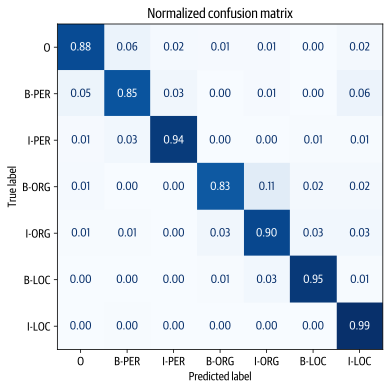

In [ ]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)